In [1]:
# =========================================
# Vehicle Emissions Analysis
# =========================================

# -------------------------------
# 1. Imports
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans

sns.set_style("whitegrid")

# -------------------------------
# 2. Load the data
# -------------------------------
vehicle_df = pd.read_csv(r"C:\Projects\Emissions_Analysis_Capstone\raw_data\vehicle_co2.csv")
print(vehicle_df.head())

    Make       Model Vehicle Class  Engine Size(L)  Cylinders Transmission  \
0  ACURA         ILX       COMPACT             2.0          4          AS5   
1  ACURA         ILX       COMPACT             2.4          4           M6   
2  ACURA  ILX HYBRID       COMPACT             1.5          4          AV7   
3  ACURA     MDX 4WD   SUV - SMALL             3.5          6          AS6   
4  ACURA     RDX AWD   SUV - SMALL             3.5          6          AS6   

  Fuel Type  Fuel Consumption City (L/100 km)  \
0         Z                               9.9   
1         Z                              11.2   
2         Z                               6.0   
3         Z                              12.7   
4         Z                              12.1   

   Fuel Consumption Hwy (L/100 km)  Fuel Consumption Comb (L/100 km)  \
0                              6.7                               8.5   
1                              7.7                               9.6   
2                   

In [8]:
# -------------------------------
# 3. Preprocessing for Regression
# -------------------------------
numeric_features = [
    "Engine Size(L)", "Cylinders",
    "Fuel Consumption City (L/100 km)",
    "Fuel Consumption Hwy (L/100 km)",
    "Fuel Consumption Comb (L/100 km)",
    "Fuel Consumption Comb (mpg)"
]

categorical_features = [
    "Make", "Model", "Vehicle Class", "Transmission", "Fuel Type"
]

target = "CO2 Emissions(g/km)"


In [9]:
# Preprocessing pipelines
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


In [4]:
# -------------------------------
# 4. Regression Model
# -------------------------------
X = vehicle_df[numeric_features + categorical_features]
y = vehicle_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=200, random_state=42))
])

rf_pipeline.fit(X_train, y_train)
y_pred = rf_pipeline.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"R² score: {r2:.4f}")
print(f"RMSE: {rmse:.2f} g/km")

R² score: 0.9964
RMSE: 3.51 g/km


In [5]:
# -------------------------------
# 5. Feature Importance
# -------------------------------
# Extract numeric + one-hot encoded feature names
ohe_columns = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_features = numeric_features + list(ohe_columns)

importances = pd.Series(
    rf_pipeline.named_steps['regressor'].feature_importances_,
    index=all_features
).sort_values(ascending=False)

print("Top 15 Feature Importances:")
print(importances.head(15))

Top 15 Feature Importances:
Fuel Consumption Comb (L/100 km)    0.783290
Fuel Consumption Comb (mpg)         0.139659
Fuel Type_E                         0.047576
Fuel Consumption City (L/100 km)    0.011797
Engine Size(L)                      0.007360
Fuel Type_D                         0.005476
Fuel Consumption Hwy (L/100 km)     0.001147
Cylinders                           0.001059
Model_FOCUS FFV                     0.000947
Model_GLA 250 4MATIC                0.000060
Transmission_AM7                    0.000060
Transmission_AS6                    0.000043
Vehicle Class_TWO-SEATER            0.000043
Transmission_A6                     0.000042
Transmission_AS7                    0.000041
dtype: float64


In [6]:
# -------------------------------
# 6. Clustering Vehicles
# -------------------------------
cluster_features = ["Engine Size(L)", "Fuel Consumption Comb (L/100 km)", "CO2 Emissions(g/km)"]
X_cluster = StandardScaler().fit_transform(vehicle_df[cluster_features])

kmeans = KMeans(n_clusters=3, random_state=42)
vehicle_df["Cluster"] = kmeans.fit_predict(X_cluster)

# Optional: descriptive cluster labels
vehicle_df["Cluster_Label"] = vehicle_df["Cluster"].map({
    0: "Low Emissions / Small Vehicles",
    1: "High Emissions / Large Vehicles",
    2: "Medium Emissions / SUVs & Mid-size"
})

C:\Users\derek\AppData\Local\Temp\ipykernel_32764\177843010.py:30: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
c:\Projects\Emissions_Analysis_Capstone\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


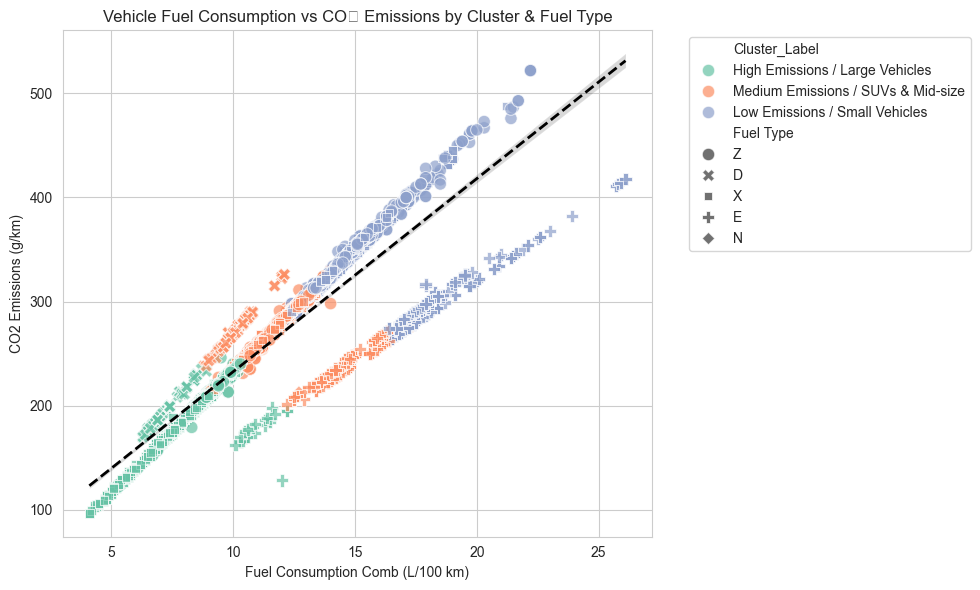

In [7]:
# -------------------------------
# 7. Visualization
# -------------------------------
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=vehicle_df,
    x="Fuel Consumption Comb (L/100 km)",
    y="CO2 Emissions(g/km)",
    hue="Cluster_Label",
    style="Fuel Type",
    palette="Set2",
    s=80,
    alpha=0.7
)

# Regression trend line (overall)
sns.regplot(
    data=vehicle_df,
    x="Fuel Consumption Comb (L/100 km)",
    y="CO2 Emissions(g/km)",
    scatter=False,
    color="black",
    line_kws={"linewidth":2, "linestyle":"--"}
)

plt.title("Vehicle Fuel Consumption vs CO₂ Emissions by Cluster & Fuel Type")
plt.xlabel("Fuel Consumption Comb (L/100 km)")
plt.ylabel("CO2 Emissions (g/km)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.tight_layout()
plt.show()

R² score: 0.9594605265600077
RMSE: 0.5853474394759323

Top 15 Feature Importances:
Engine Size(L)                   0.722542
Fuel Type_E                      0.110234
Vehicle Class_VAN - PASSENGER    0.019989
Vehicle Class_MID-SIZE           0.011496
Cylinders                        0.009201
Vehicle Class_SUV - STANDARD     0.007823
Make_FORD                        0.006913
Transmission_AV                  0.006664
Fuel Type_Z                      0.006397
Transmission_AM7                 0.005438
Vehicle Class_SUV - SMALL        0.004744
Fuel Type_D                      0.004720
Make_MASERATI                    0.004021
Vehicle Class_FULL-SIZE          0.003739
Vehicle Class_COMPACT            0.003587
dtype: float64


C:\Users\derek\AppData\Local\Temp\ipykernel_32764\4232415842.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.head(15), y=feature_importances.head(15).index, palette="viridis")


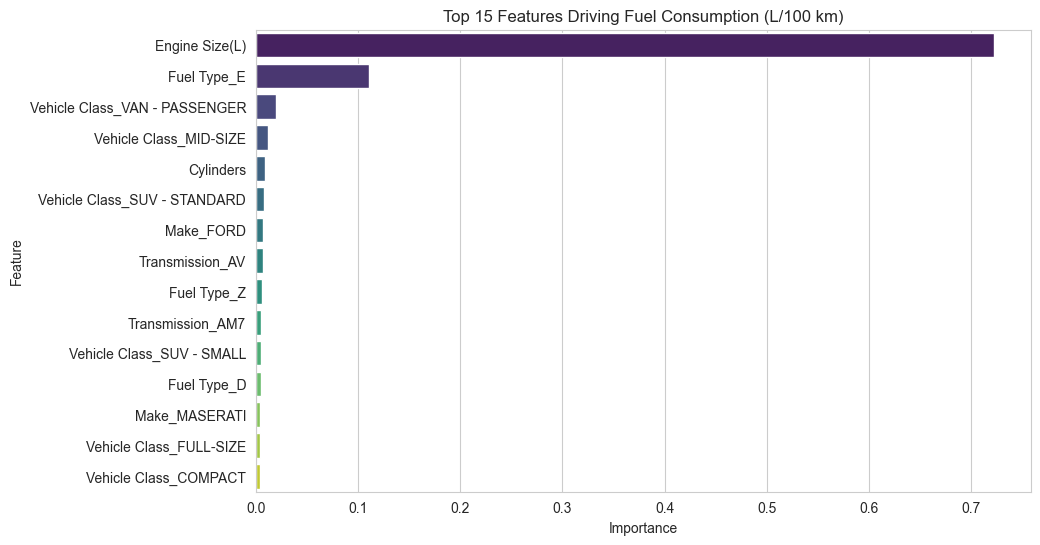

: 

In [ ]:
# Load data
vehicles_df = pd.read_csv(r"C:\Projects\Emissions_Analysis_Capstone\raw_data\vehicle_co2.csv")

# Define target and features
target = "Fuel Consumption Comb (L/100 km)"
numeric_features = ["Engine Size(L)", "Cylinders"]
categorical_features = ["Vehicle Class", "Transmission", "Fuel Type", "Make"]

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ]
)

# Train/test split
X = vehicles_df[numeric_features + categorical_features]
y = vehicles_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Pipeline
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=200, random_state=42))
])

rf_pipeline.fit(X_train, y_train)

# Predictions
y_pred = rf_pipeline.predict(X_test)
print("R² score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# -------------------------------
# Feature Importance Extraction
# -------------------------------
# Get numeric + one-hot encoded feature names
encoded_cat_names = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(encoded_cat_names)

# Extract importances
importances = rf_pipeline.named_steps['regressor'].feature_importances_
feature_importances = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)
print("\nTop 15 Feature Importances:")
print(feature_importances.head(15))

# Optional: visualize
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances.head(15), y=feature_importances.head(15).index, palette="viridis")
plt.title("Top 15 Features Driving Fuel Consumption (L/100 km)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()